### Inicjalizacja

In [3]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
from imutils import perspective
from draw_images import draw_images

# model_path = '../res/input/target.jpg'
# video_path = '../res/input/video.mp4'
model_path = '../res/input/target3.jpg'
video_path = '../res/input/02.mp4'
model = cv2.imread(model_path)
cap = cv2.VideoCapture(video_path)

cap.get(cv2.CAP_PROP_FRAME_COUNT) # Get frame count of movie
cap.set(cv2.CAP_PROP_POS_MSEC, 2000) # frame at 4000ms
_, frame = cap.read()
# frame = frame[250:950,580:1300]

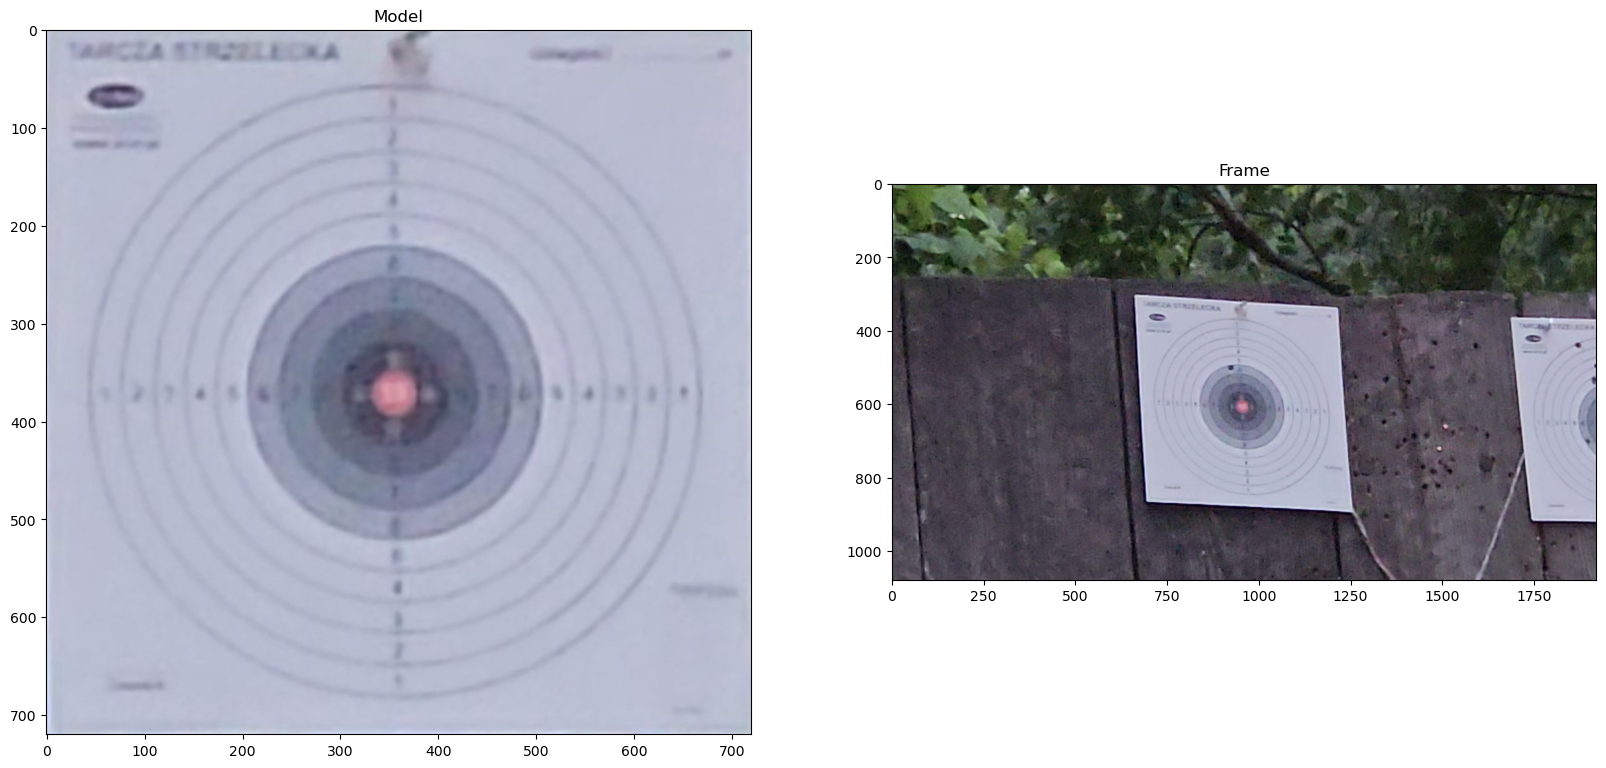

In [4]:
draw_images([
    ('Model', cv2.cvtColor(model, cv2.COLOR_BGR2RGB), None),
    ('Frame', cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), None)
], 1, 2, (20, 20))

### Konwersja do skali szarości

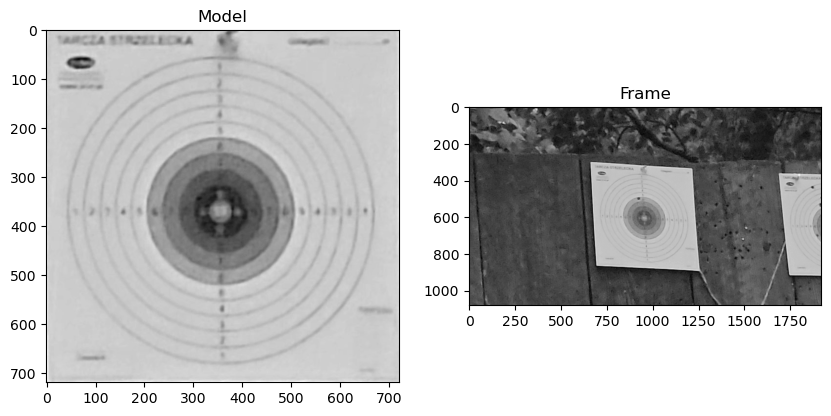

In [5]:
model_gray = cv2.cvtColor(model, cv2.COLOR_RGB2GRAY)
frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

kernel = (7, 7)
cv2.GaussianBlur(model_gray, kernel, 0)
cv2.GaussianBlur(frame_gray, kernel, 0)

draw_images([
    ('Model', model_gray, 'gray'),
    ('Frame', frame_gray, 'gray')
], 1, 2, (10, 20))

### Dopasowywanie

In [6]:
sift_matcher = cv2.SIFT_create()
model_keys, model_desc = sift_matcher.detectAndCompute(model_gray, None)
frame_keys, frame_desc = sift_matcher.detectAndCompute(frame_gray, None)

bf_matcher = cv2.BFMatcher(crossCheck=False)
best_match = []
ratio = .75

if type(frame_desc) != type(None):
    # apply ratio test
    matches = bf_matcher.knnMatch(model_desc, frame_desc, k=2)
    
    for m1, m2 in matches:
        if m1.distance < ratio * m2.distance:
            best_match.append(m1)

### Szukanie homografii

https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

Wypakowywanie lokalizacji powiązanych miejsc kluczowych:

In [7]:
# extracting the location of matched keypoints
model_pts = np.float32([ model_keys[m.queryIdx].pt for m in best_match ]).reshape(-1,1,2)
frame_pts = np.float32([ frame_keys[m.trainIdx].pt for m in best_match ]).reshape(-1,1,2)


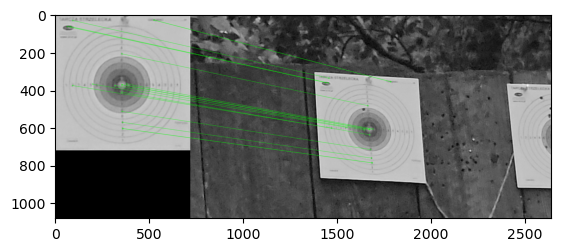

(<matplotlib.image.AxesImage at 0x7f32f411c4f0>, None)

In [8]:
M, mask = cv2.findHomography(frame_pts, model_pts, cv2.LMEDS, 7.0)
matchesMask = mask.ravel().tolist()
h,w = model_gray.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts, M)
# img2 = cv2.polylines(frame_gray, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
 singlePointColor = None,
 matchesMask = matchesMask, # draw only inliers
 flags = 2)
img3 = cv2.drawMatches(model_gray, model_keys, frame_gray, frame_keys, best_match, None, **draw_params)
plt.imshow(img3, 'gray'),plt.show()

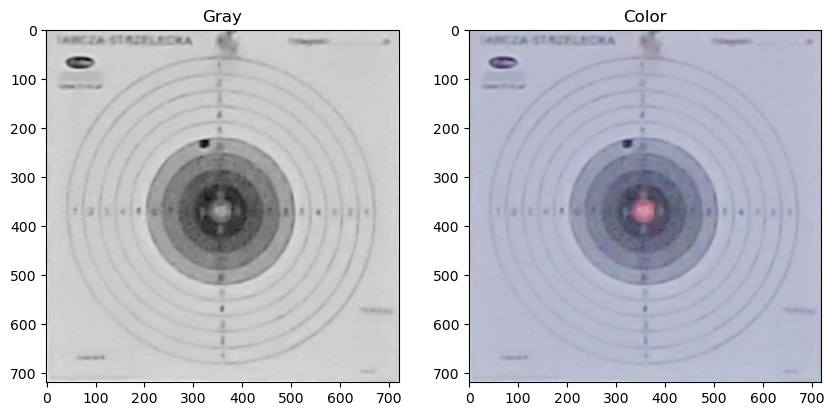

In [9]:
warped_frame_gray = cv2.warpPerspective(frame_gray, M, (w, h))
warped_frame = cv2.warpPerspective(frame, M, (w, h))
draw_images([
    ('Gray', warped_frame_gray, 'gray'),
    ('Color', cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB), None)
], 1, 2, (10, 10))

### Odszumianie

Parametry funkcji `fastNlMeansDenoising`\
`src` - Input 8-bit 3-channel image\
`dst` - Output image with the same size and type as src.\
`templateWindowSize` - Size in pixels of the template patch that is used to compute weights. Should be odd. Recommended value 7 pixels\
`searchWindowSize` - Size in pixels of the window that is used to compute weighted average for given pixel. Should be odd. Affect performance linearly: greater searchWindowsSize - greater denoising time. Recommended value 21 pixels\
`h` - Array of parameters regulating filter strength, either one parameter applied to all channels or one per channel in dst. Big h value perfectly removes noise but also removes image details, smaller h value preserves details but also preserves some noise\


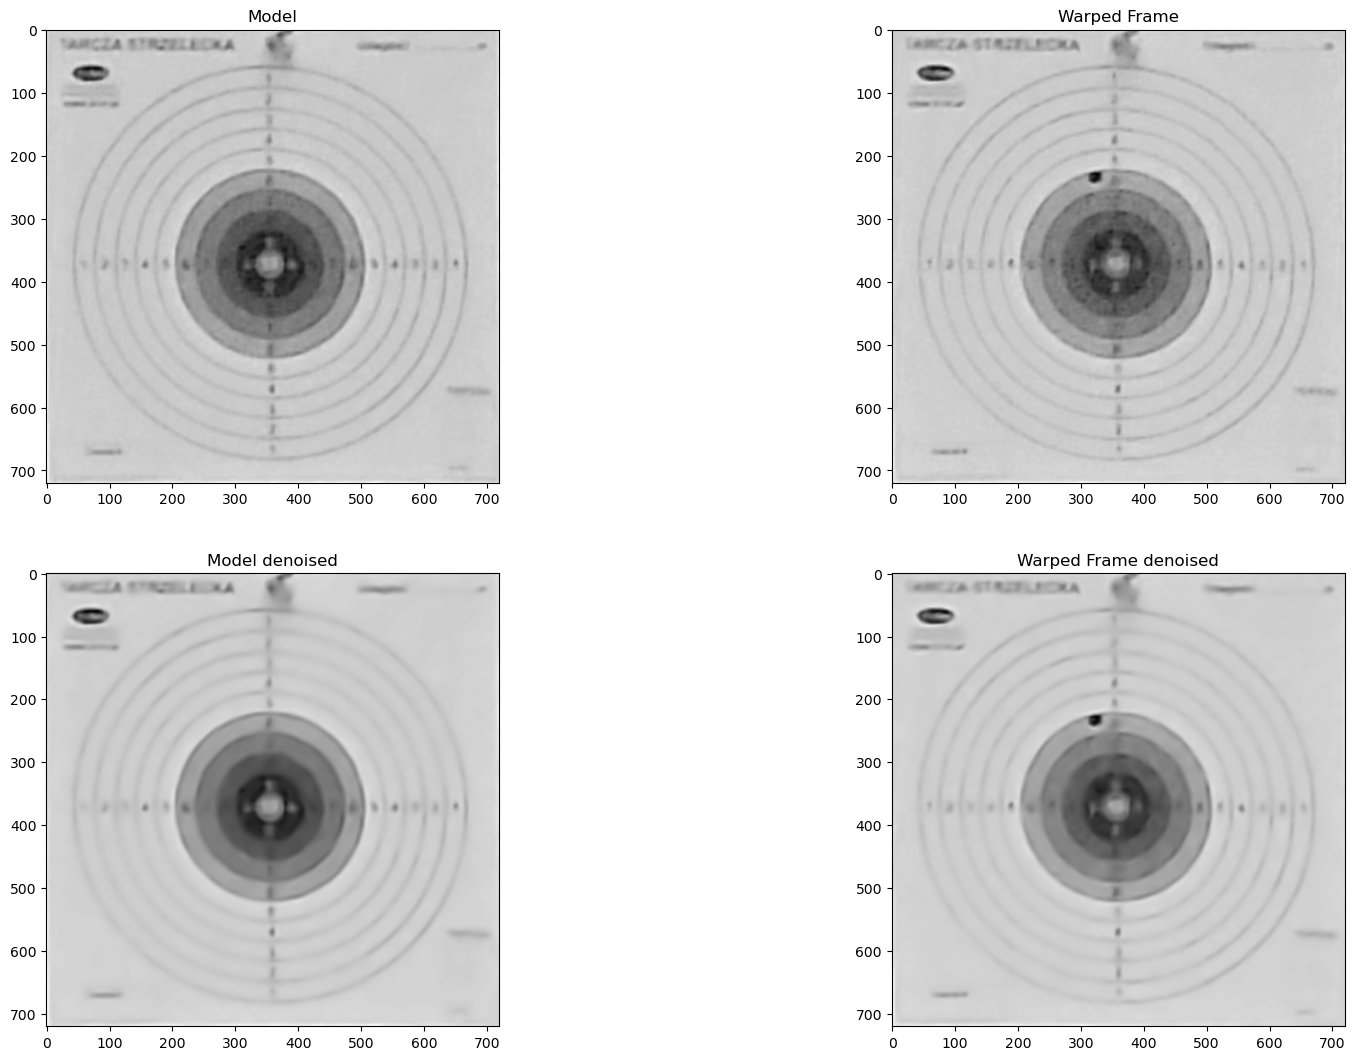

In [10]:
model_gray_denoised = np.empty(model_gray.shape, np.uint8)
cv2.fastNlMeansDenoising(model_gray, model_gray_denoised, 7, 21, 17)
w_frame_gray_denoised = np.empty(warped_frame_gray.shape, np.uint8)
cv2.fastNlMeansDenoising(warped_frame_gray, w_frame_gray_denoised, 7, 21, 12)

draw_images([
    ('Model', model_gray, 'gray'),
    ('Warped Frame', warped_frame_gray, 'gray'),
    ('Model denoised', model_gray_denoised, 'gray'),
    ('Warped Frame denoised', w_frame_gray_denoised, 'gray'),
], 3, 2, (20, 20))

### Różnica modelu i wyciętej ramki

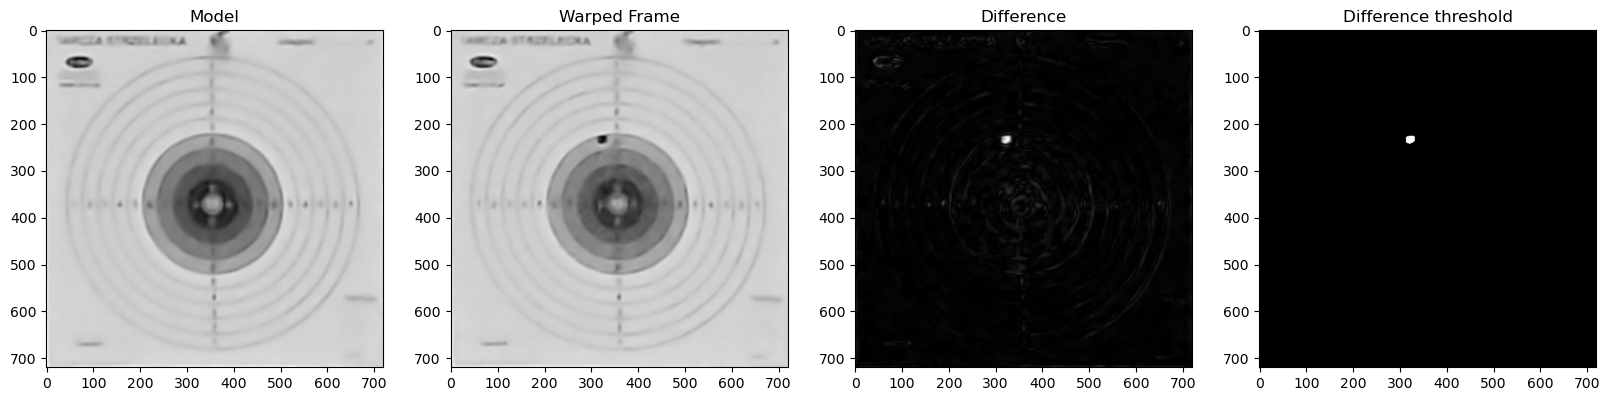

In [11]:
diff = cv2.absdiff(w_frame_gray_denoised, model_gray_denoised)
_, diff_t = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)

draw_images([
    ('Model', model_gray_denoised, 'gray'),
    ('Warped Frame', w_frame_gray_denoised, 'gray'),
    ('Difference', diff, 'gray'),
    ('Difference threshold', diff_t, 'gray')
], 1, 4, (20, 50))

### Wykrywanie obiektu

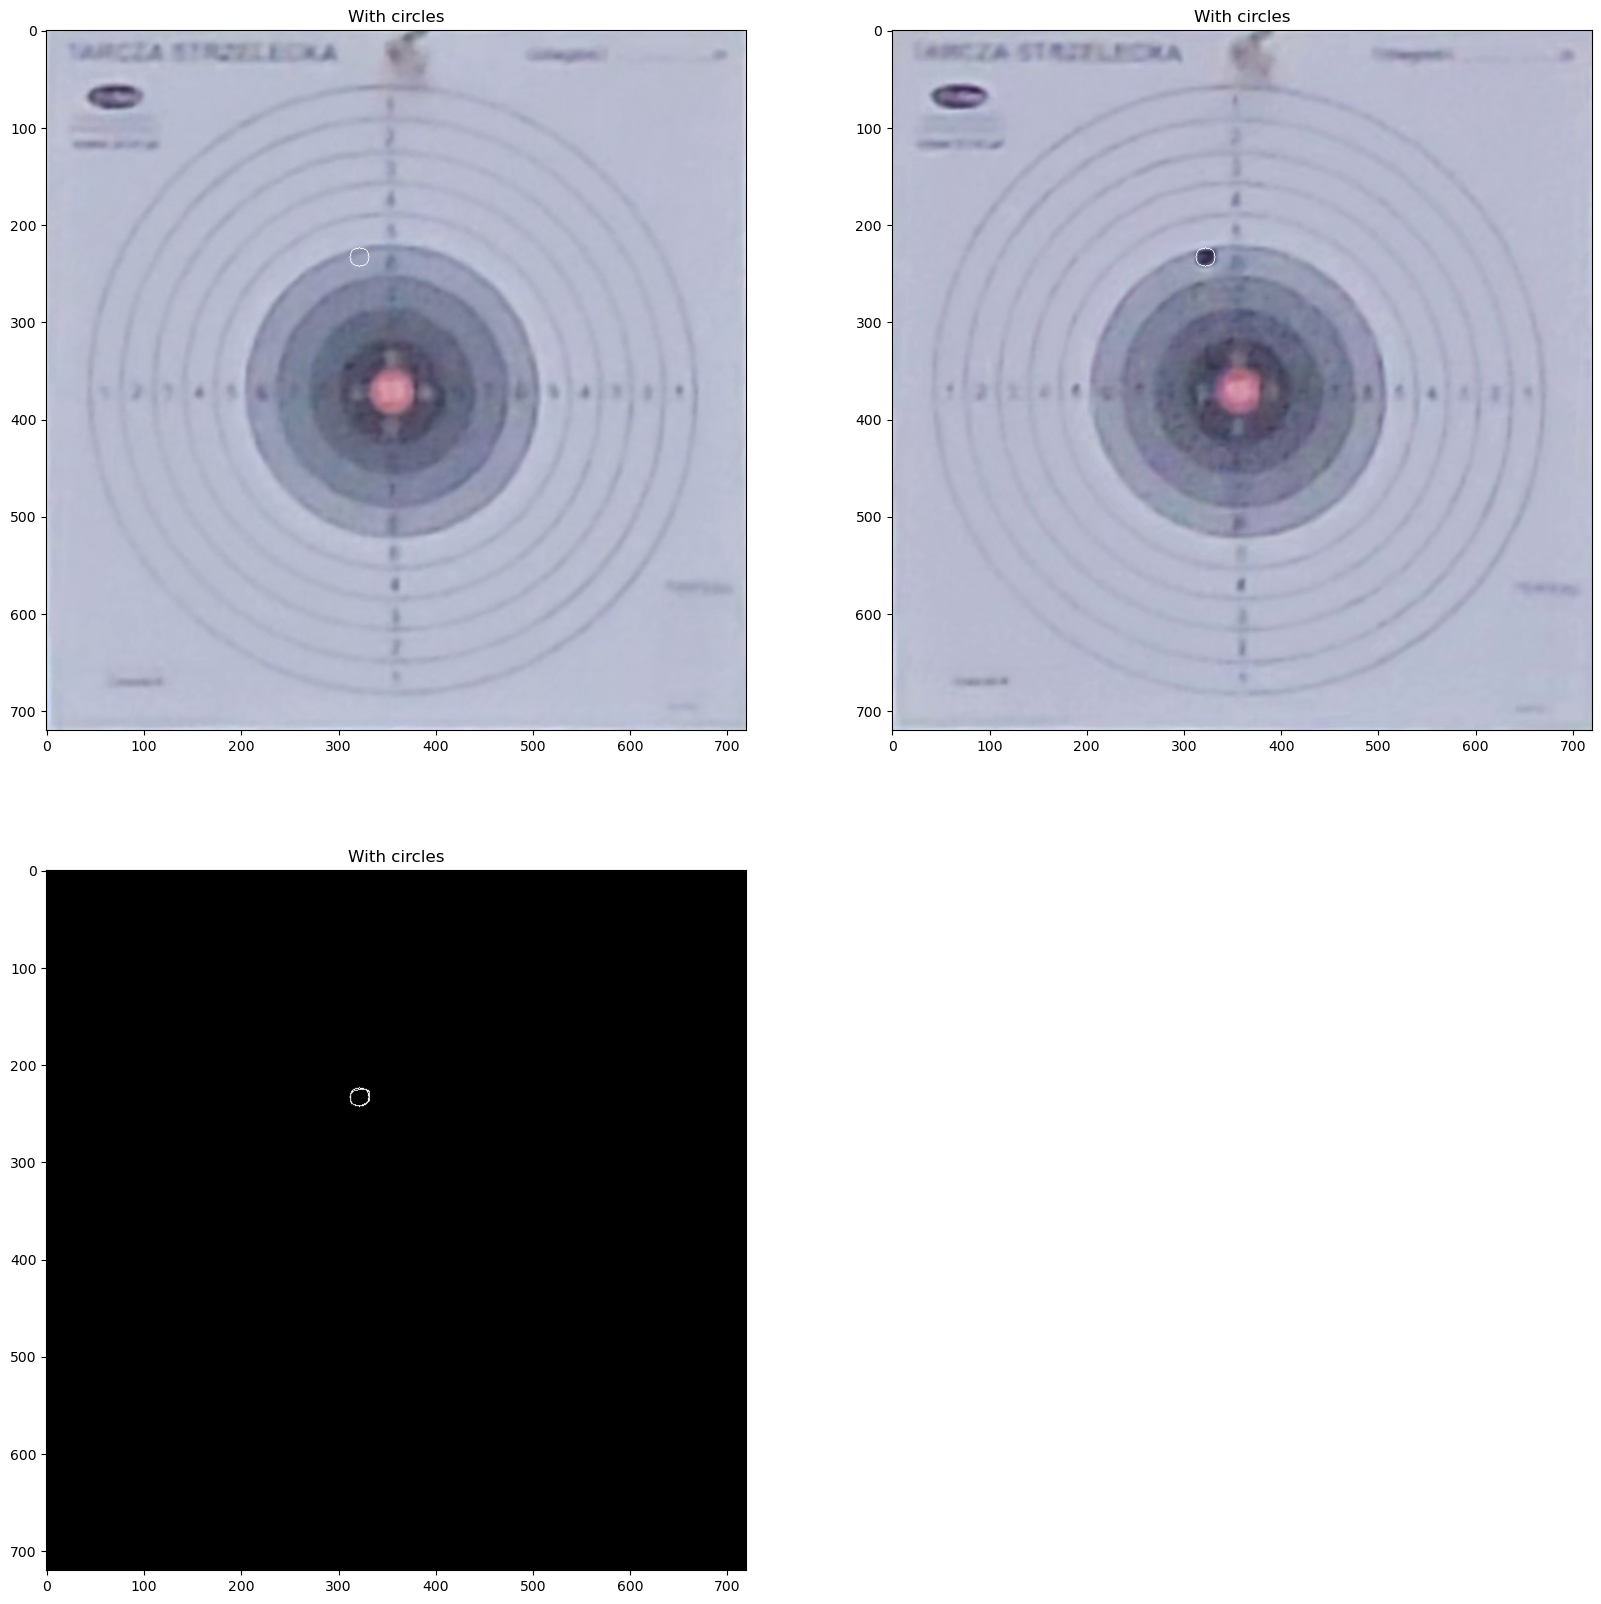

In [12]:
warped_frame_circles = np.copy(warped_frame)
model_circles = np.copy(model)
edged = cv2.Canny(diff_t, 25, 75)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

counturs = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
counturs = imutils.grab_contours(counturs)
for countur in counturs:
    # get centre of contour
    moments = cv2.moments(countur)
    cX = int(moments["m10"] / moments["m00"])
    cY = int(moments["m01"] / moments["m00"])
    cv2.circle(edged, (cX, cY), 10, (255, 255, 255), 1)
    cv2.circle(warped_frame, (cX, cY), 10, (255, 255, 255), 1)
    cv2.circle(model, (cX, cY), 10, (255, 255, 255), 1)

draw_images([
    ('With circles', cv2.cvtColor(model, cv2.COLOR_BGR2RGB), None),
    ('With circles', cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB), None),
    ('With circles', cv2.cvtColor(edged, cv2.COLOR_BGR2RGB), None)
], 2, 2, (20, 20))